# Bayesian Dynamic TWFE

In [2]:
import re
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [48]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

## Dynamic TWFE

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{l \in L} \delta_l \mathbf{1}[t - k_i = l] + \epsilon_{it}
$$

ベイズ

$$
\begin{aligned}
\log{Y_{it}} &\sim \mathcal{t}(\nu=3, \mu_{it}, \sigma^2) \\
\mu_{it} &= \text{intercept} + (\beta + \gamma_{\ell}) T_{it} + \text{island}_i + \text{year}_t \\
\sigma &\sim \text{Half-}\mathcal{t}(\nu=3, \sigma=1) \\
\text{intercept} &\sim \mathcal{N}(0, 1) \\
\beta &\sim \mathcal{N}(0, 1) \\
\gamma_{\ell} &\sim \mathcal{N}(\mu_{\gamma}, \sigma_{\gamma}) \\
\text{island}_i &\sim \mathcal{N}(\mu_{\text{island}}, \sigma_{\text{island}}) \\
\text{year}_t &\sim \mathcal{N}(\mu_{\text{year}}, \sigma_{\text{year}}) \\
\mu_{\gamma} &\sim \mathcal{N}(0, 1) \\
\sigma_{\gamma} &\sim \text{Half-}\mathcal{t}(\nu=3, 1) \\
\mu_{\text{island}} &\sim \mathcal{N}(0, 1) \\
\sigma_{\text{island}} &\sim \text{Half-}\mathcal{t}(\nu=3, 1) \\
\mu_{\text{year}} &\sim \mathcal{N}(0, 1) \\
\sigma_{\text{year}} &\sim \text{Half-}\mathcal{t}(\nu=3, 1) \\
\end{aligned}
$$

### ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


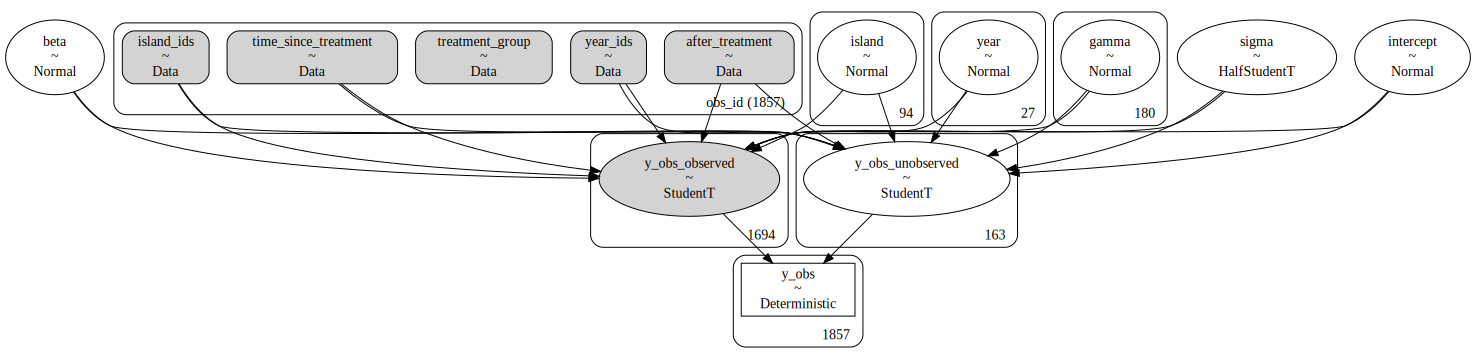

In [9]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['year'], unique_years = pd.factorize(df['year'])
# df['time_since_treatment'], unique_time_since_treatment = pd.factorize(df['time_since_treatment'])
time_since_treatment_max = df['time_since_treatment'].max()
time_since_treatment_min = df['time_since_treatment'].min()
shape_time_since_treatment = int(time_since_treatment_max - time_since_treatment_min + 1)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as dynamic_twfe:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['year'], dims='obs_id')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='obs_id')
    after_treatment = pm.Data('after_treatment', df['after_treatment'], dims='obs_id')
    time_since_treatment = pm.Data('time_since_treatment', df['time_since_treatment'], dims='obs_id')

    # priors
    # random effect
    island = pm.Normal('island', mu=0, sigma=1, shape=len(unique_island_ids))
    year = pm.Normal('year', mu=0, sigma=1, shape=len(unique_years))
    gamma = pm.Normal(
        'gamma', mu=0, sigma=1,
        shape=shape_time_since_treatment
    ) # 時間変動の介入効果

    # fixed effect
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1) # 時間固定の介入効果
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    gamma_index = time_since_treatment - time_since_treatment_min
    mu = intercept + (beta + gamma[gamma_index]) * after_treatment + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(dynamic_twfe)

In [20]:
with dynamic_twfe:
    initvals = {'intercept': 5, 'beta': 0.4, 'sigma': 0.1}
    trace_dynamic_twfe = pm.sample(
        draws=3000,
        tune=800,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
        initvals=initvals
    )
    pm.compute_log_likelihood(trace_dynamic_twfe)

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/3800 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [23]:
az.summary(
    trace_dynamic_twfe,
    var_names=['intercept', 'beta', 'sigma'],
    hdi_prob=0.95
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.636,0.207,5.251,6.069,0.015,0.011,186.0,365.0,1.01
beta,0.470,0.130,0.228,0.741,0.012,0.009,117.0,196.0,1.02
sigma,0.111,0.003,0.105,0.117,0.000,0.000,4695.0,4554.0,1.00


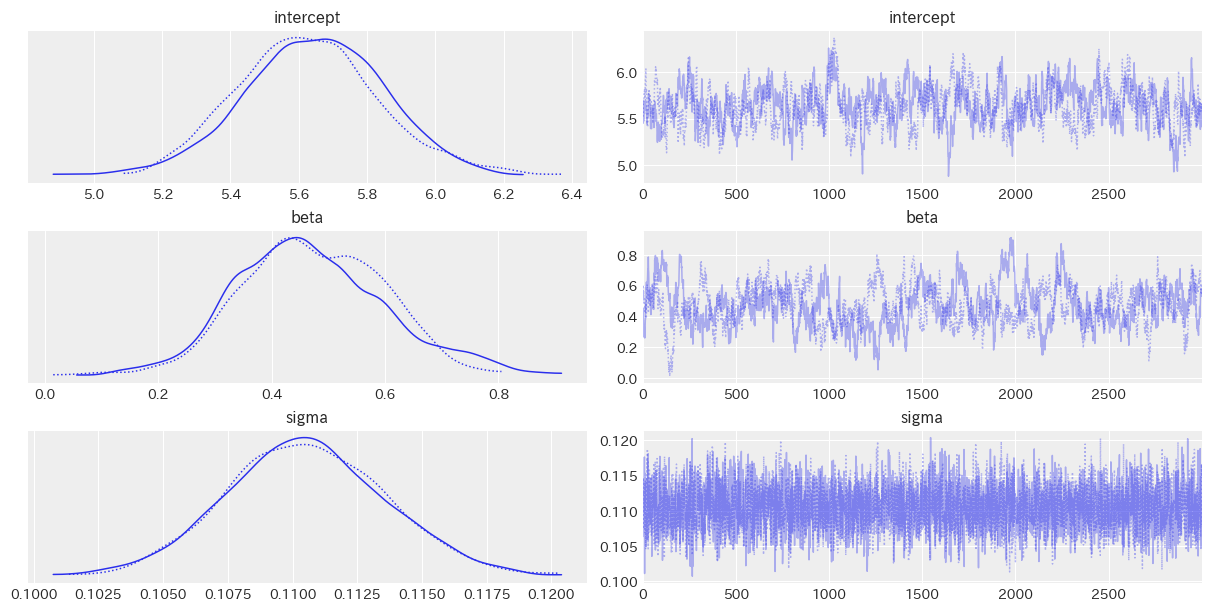

In [22]:
az.plot_trace(
    trace_dynamic_twfe,
    var_names=['intercept', 'beta', 'sigma']
);

In [32]:
az.waic(trace_dynamic_twfe)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 6000 posterior samples and 1694 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   448.85    56.39
p_waic      208.41        -

There has been a warning during the calculation. Please check the results.

In [12]:
print(f'{np.exp(0.469):.3f}')

1.598


### 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


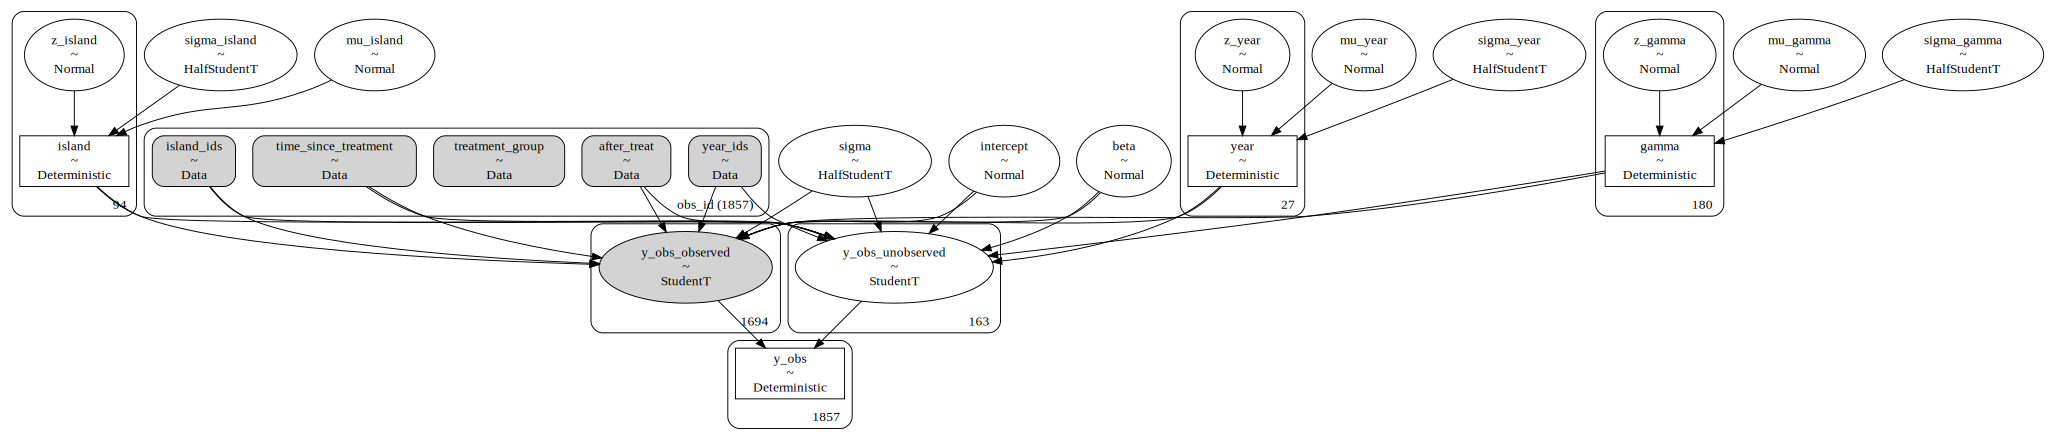

In [51]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['year'], unique_years = pd.factorize(df['year'])

time_since_treatment_max = df['time_since_treatment'].max()
time_since_treatment_min = df['time_since_treatment'].min()
shape_time_since_treatment = int(time_since_treatment_max - time_since_treatment_min + 1)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as dynamic_twfe_h:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['year'], dims='obs_id')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='obs_id')
    after_treat = pm.Data('after_treat', df['after_treatment'], dims='obs_id')
    time_since_treatment = pm.Data('time_since_treatment', df['time_since_treatment'], dims='obs_id')

    # priors
    # random effect
    mu_island = pm.Normal('mu_island', mu=0, sigma=0.5)
    sigma_island = pm.HalfStudentT('sigma_island', nu=3, sigma=0.5)
    z_island = pm.Normal('z_island', mu=0, sigma=0.5, shape=len(unique_island_ids))
    island = pm.Deterministic('island', mu_island + sigma_island * z_island)

    mu_year = pm.Normal('mu_year', mu=0, sigma=0.5)
    sigma_year = pm.HalfStudentT('sigma_year', nu=3, sigma=0.5)
    z_year = pm.Normal('z_year', mu=0, sigma=0.5, shape=len(unique_years))
    year = pm.Deterministic('year', mu_year + sigma_year * z_year)

    mu_gamma = pm.Normal('mu_gamma', mu=0, sigma=0.5)
    sigma_gamma = pm.HalfStudentT('sigma_gamma', nu=3, sigma=0.5)
    z_gamma = pm.Normal('z_gamma', mu=0, sigma=0.5, shape=shape_time_since_treatment)
    gamma = pm.Deterministic('gamma', mu_gamma + sigma_gamma * z_gamma)

    # fixed effect
    intercept = pm.Normal('intercept', mu=0, sigma=0.5)
    beta = pm.Normal('beta', mu=0, sigma=0.5) # 時間固定の介入効果
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=0.5)

    # expectation
    gamma_index = time_since_treatment - time_since_treatment_min
    mu = intercept + (beta + gamma[gamma_index]) * after_treat + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(dynamic_twfe_h)

In [ ]:
with dynamic_twfe_h:
    initvals = {'intercept': 2, 'beta': 0.4, 'sigma': 0.1}
    trace_dynamic_twfe_h = pm.sample(
        draws=3000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
        initvals=initvals
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [41]:
az.summary(
    trace_dynamic_twfe_h,
    var_names=['intercept', 'beta', 'sigma'],
    hdi_prob=0.95
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.819,0.772,0.406,3.397,0.070,0.051,122.0,352.0,1.01
beta,-0.026,0.642,-1.789,0.947,0.314,0.240,5.0,21.0,1.43
sigma,0.113,0.003,0.107,0.120,0.000,0.000,3269.0,3573.0,1.00


/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


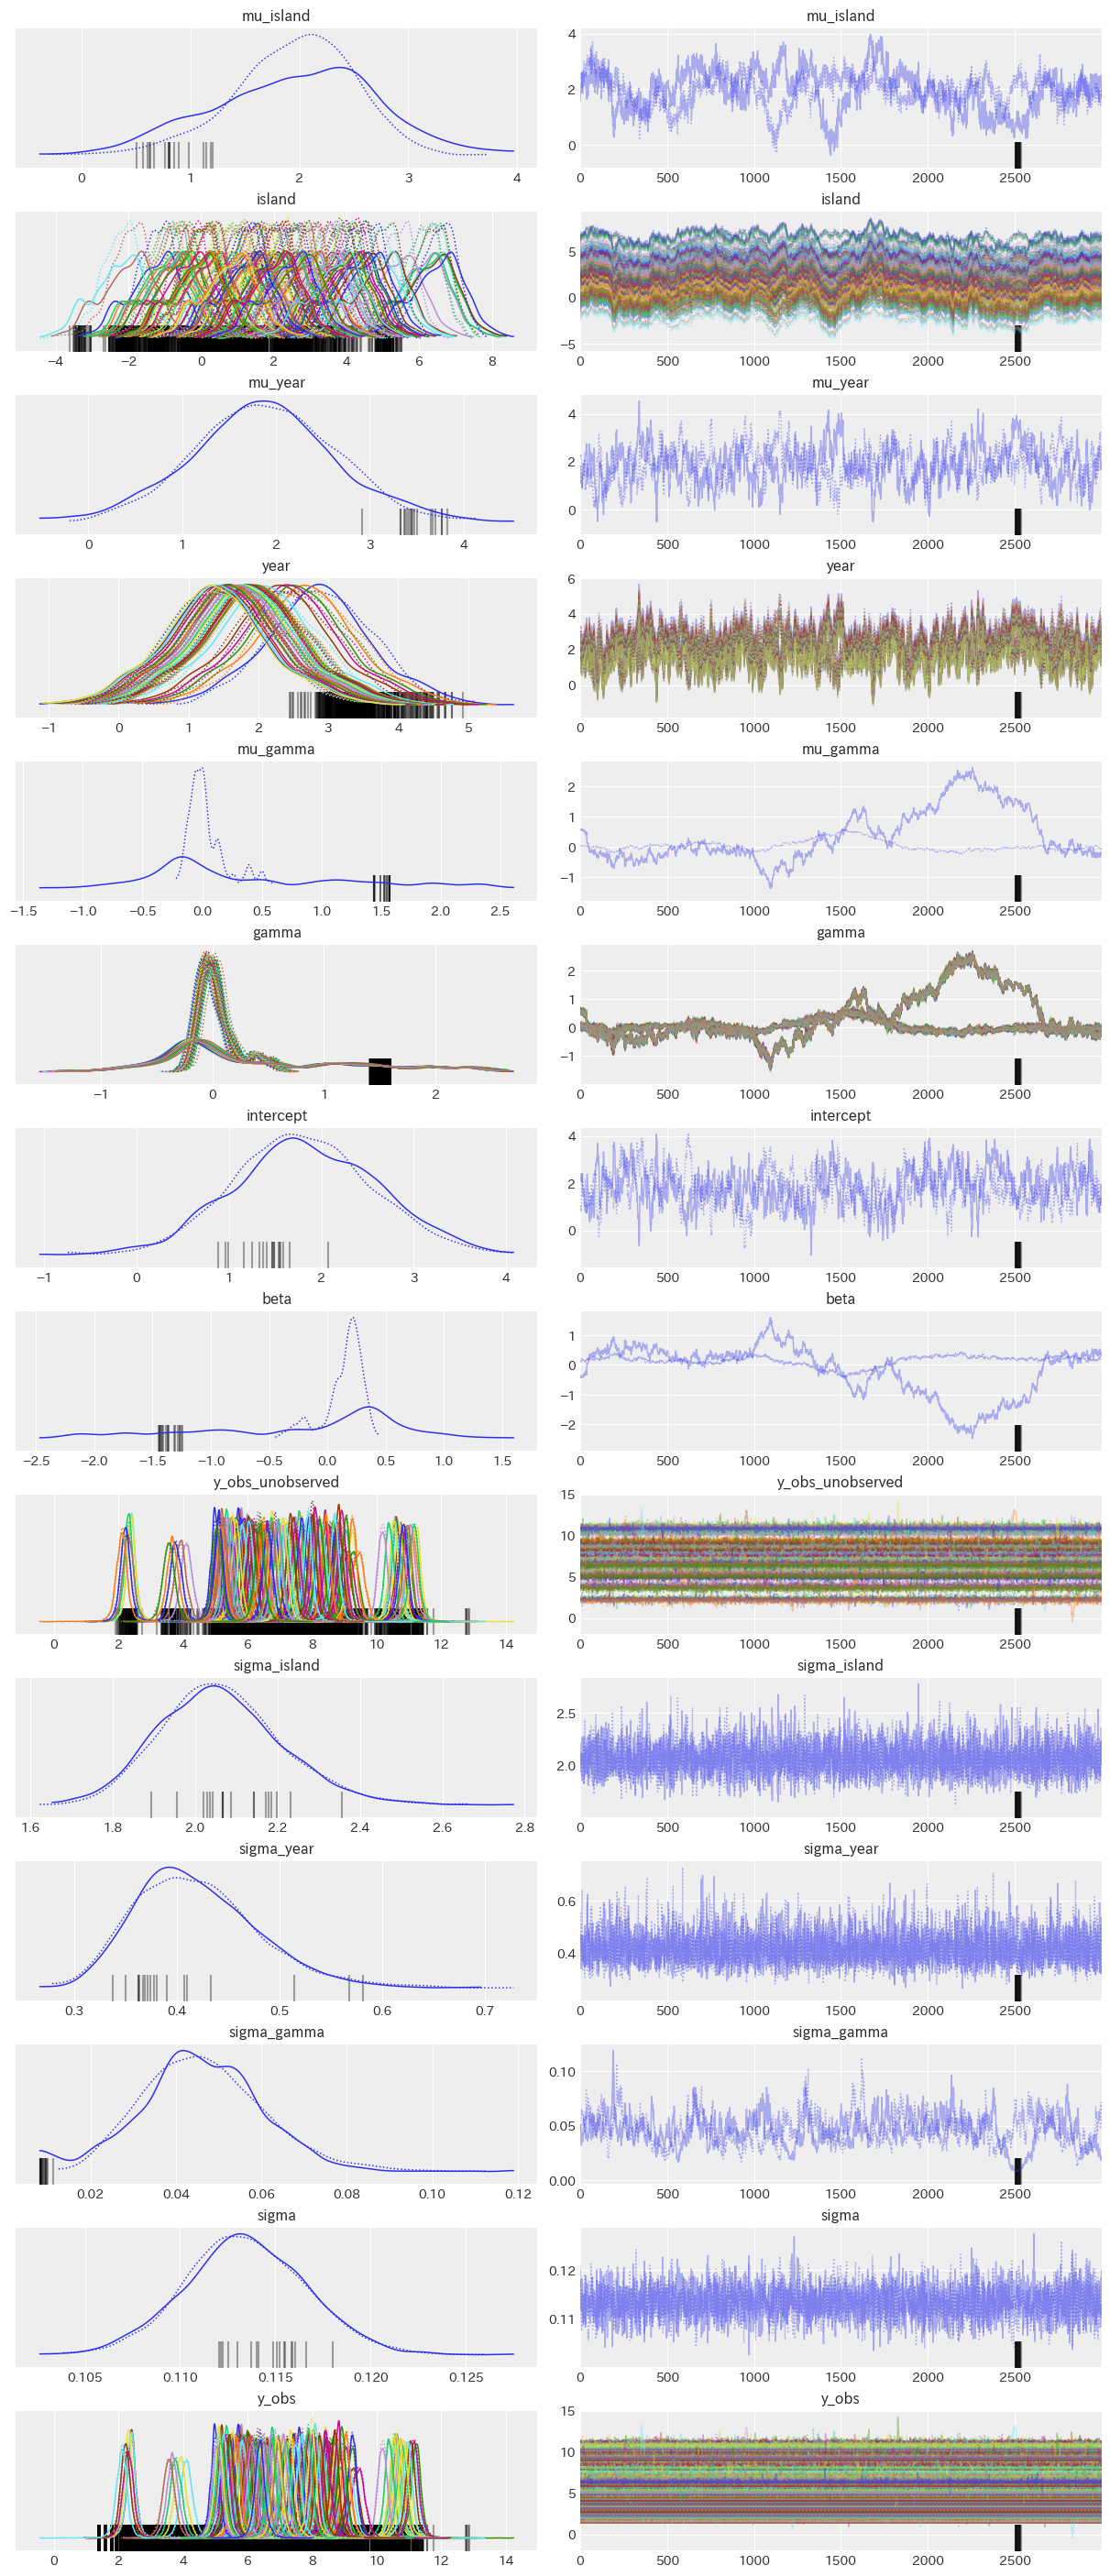

In [42]:
az.plot_trace(trace_dynamic_twfe_h);

In [31]:
with dynamic_twfe_h:
    pm.compute_log_likelihood(trace_dynamic_twfe_h)

az.waic(trace_dynamic_twfe_h)

Output()

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 6000 posterior samples and 1694 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   437.12    56.38
p_waic      165.45        -

There has been a warning during the calculation. Please check the results.

## サンプリングの保存

In [33]:
az.to_netcdf(trace_dynamic_twfe, './sample/trace_dynamic_twfe_log.nc')
az.to_netcdf(trace_dynamic_twfe_h, './sample/trace_dynamic_twfe_h_log.nc')

'./sample/trace_dynamic_twfe_h_log.nc'

## サンプリングのインポート

In [44]:
trace_dynamic_twfe = az.from_netcdf('./sample/trace_dynamic_twfe_log.nc')
trace_dynamic_twfe_h = az.from_netcdf('./sample/trace_dynamic_twfe_h_log.nc')

## 時間変動のプロット

In [36]:
def get_beta_df(trace):
    # ベータのサマリーを取得
    beta_df = az.summary(trace, var_names=['beta'], hdi_prob=0.95, kind='stats')
    return beta_df

def get_gamma_df(trace):
    # デルタのサマリーを取得
    gamma_df = az.summary(trace, var_names=['gamma'], hdi_prob=0.95, kind='stats')

    # 経過年数
    time_since_intervention_list = df['time_since_treatment'].unique()
    time_since_intervention_df = pd.DataFrame(time_since_intervention_list, columns=['time_since_treatment'])

    # デルタの値を経過年数と結合
    # デルタの順番は経過年数の昇順ではなく，データに登場した順番になっている．
    gamma_df.reset_index(drop=True, inplace=True)
    gamma_df = pd.concat([gamma_df, time_since_intervention_df], axis=1)

    gamma_df['exp_mean'] = np.exp(gamma_df['mean']) - 1
    gamma_df['exp_hdi_2.5%'] = np.exp(gamma_df['hdi_2.5%']) - 1
    gamma_df['exp_hdi_97.5%'] = np.exp(gamma_df['hdi_97.5%']) - 1

    return gamma_df

def plot_effects_over_time_log(gamma_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='time_since_treatment',
        y='mean',
        data=gamma_df,
        marker='o',
        color='black',
        label='Mean'
    )
    # エラーバー
    plt.errorbar(
        x=gamma_df['time_since_treatment'],
        y=gamma_df['mean'],
        yerr=[
            gamma_df['mean'] - gamma_df['hdi_2.5%'],
            gamma_df['hdi_97.5%'] - gamma_df['mean']
        ],
        fmt='o',
        color='black',
        alpha=0.5,
        capsize=5,
        label='95% HDI'
    )
    plt.axvline(x=0, color='black', linestyle=':')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.xlabel('Time since Treatment')
    plt.ylabel('Effects')
    plt.title('Random Effects Over Time')
    plt.legend()
    plt.show()

def plot_effects_over_time_exp(gamma_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='time_since_treatment',
        y='exp_mean',
        data=gamma_df,
        marker='o',
        color='black',
        label='Mean'
    )
    # エラーバー
    plt.errorbar(
        x=gamma_df['time_since_treatment'],
        y=gamma_df['exp_mean'],
        yerr=[
            gamma_df['exp_mean'] - gamma_df['exp_hdi_2.5%'],
            gamma_df['exp_hdi_97.5%'] - gamma_df['exp_mean']
        ],
        fmt='o',
        color='black',
        alpha=0.5,
        capsize=5,
        label='95% HDI'
    )
    plt.axvline(x=0, color='black', linestyle=':')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.xlabel('Time since Treatment')
    plt.ylabel('Effects')
    plt.title('Random Effects Over Time')
    plt.legend()
    plt.show()

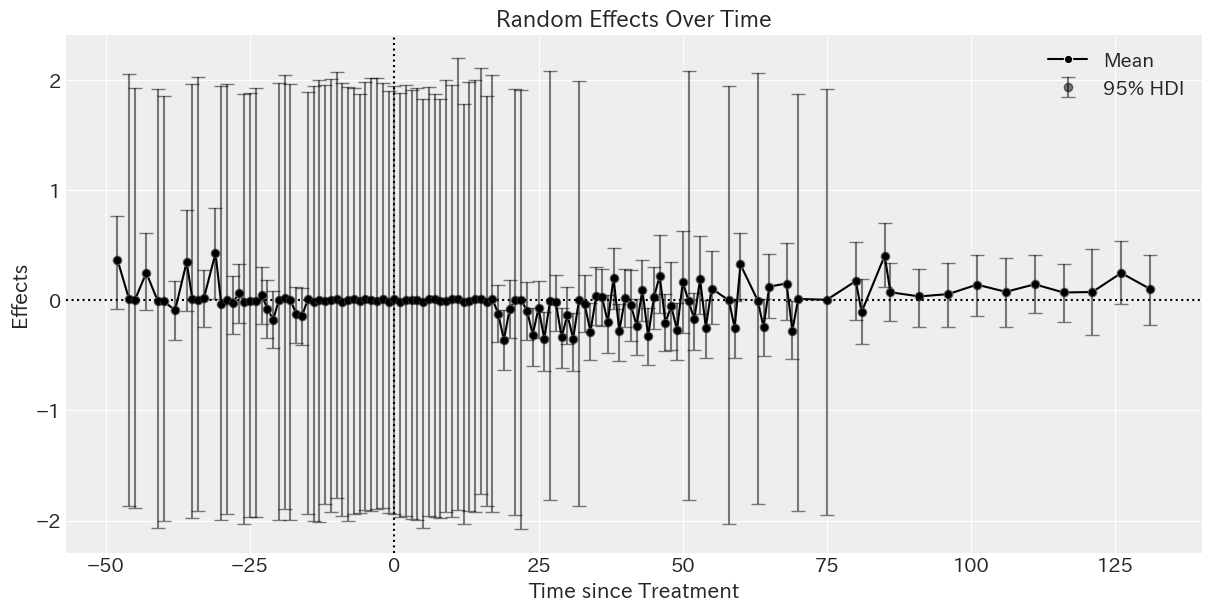

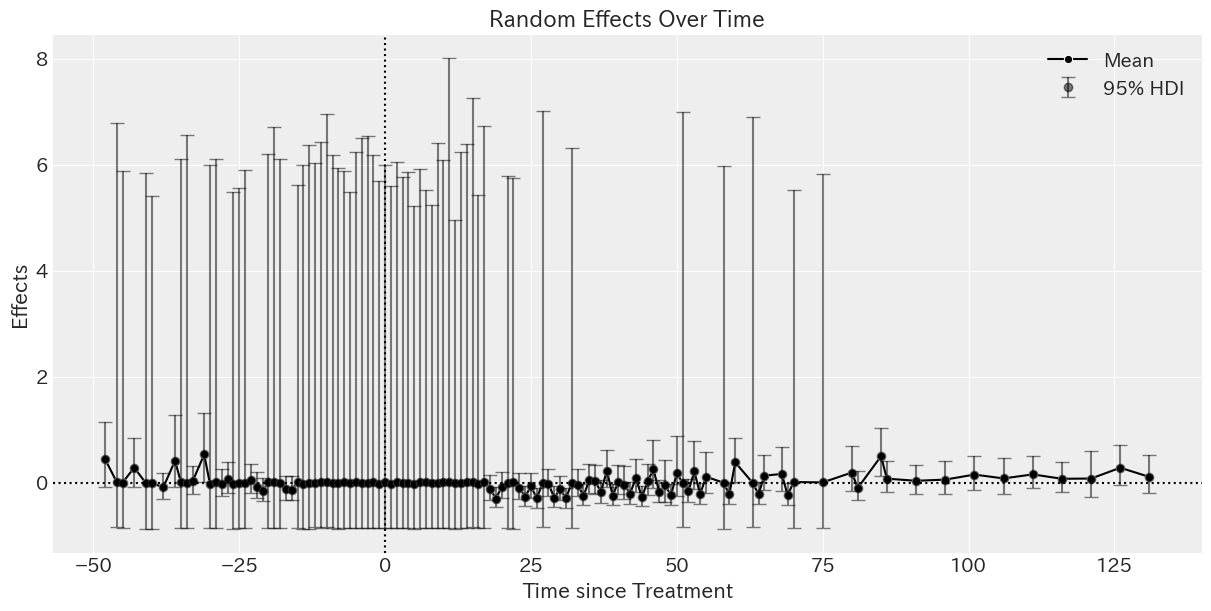

In [37]:
gamma_df = get_gamma_df(trace_dynamic_twfe)
plot_effects_over_time_log(gamma_df)
plot_effects_over_time_exp(gamma_df)

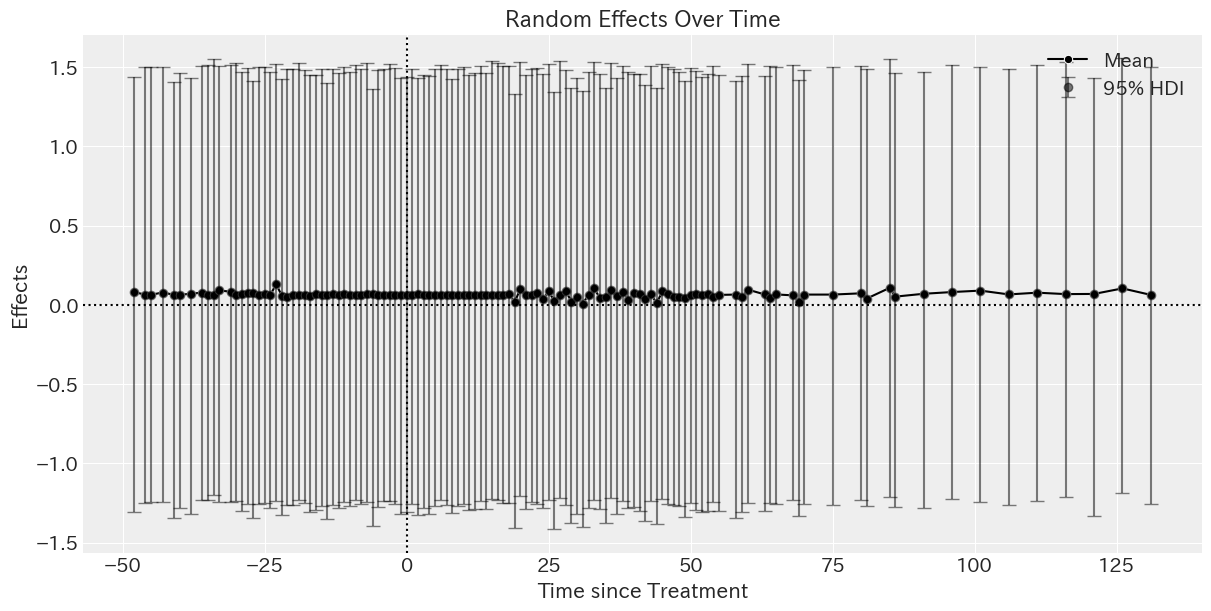

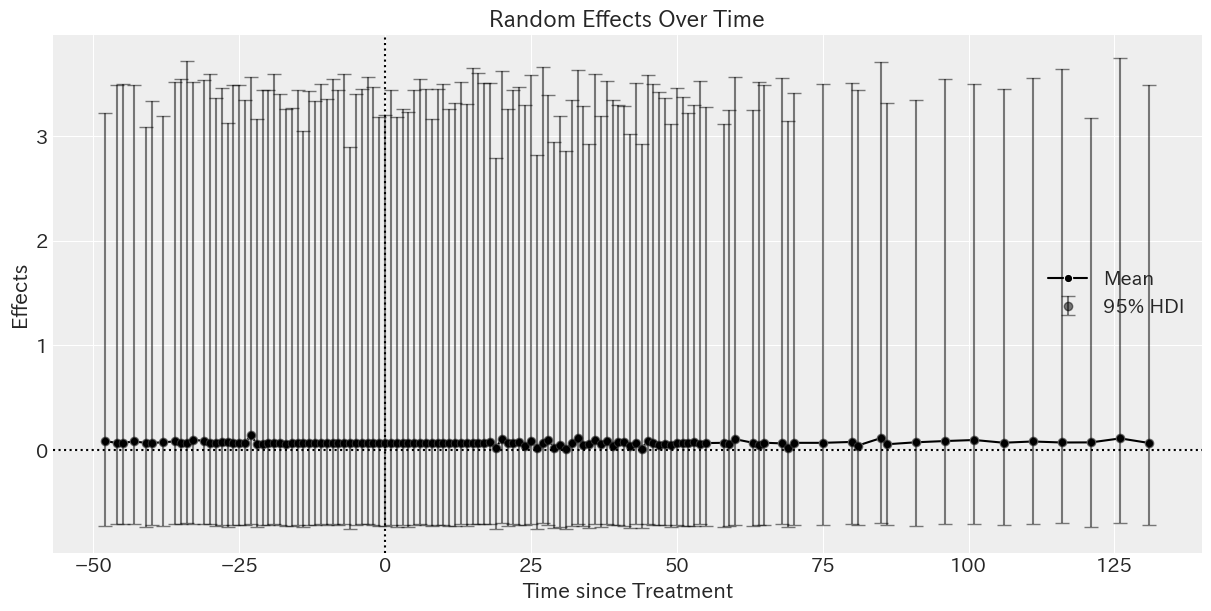

In [45]:
gamma_df = get_gamma_df(trace_dynamic_twfe_h)
plot_effects_over_time_log(gamma_df)
plot_effects_over_time_exp(gamma_df)